In [1]:
#pip install opencv-contrib-python

In [2]:
#try:
  # This %tensorflow_version magic only works in Colab.
#  %tensorflow_version 1.x
#except Exception:
#  pass
# For your non-Colab code, be sure you have tensorflow==1.15
import tensorflow as tf
#assert tf.__version__.startswith('1')

#tf.enable_eager_execution()

import os
import numpy as np
import matplotlib.pyplot as plt


args = {"dataset":"./consolidated_data", "plot":"plot.png", "model":"mask_detector.h5"}

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20

#Prepare training and validation data
IMAGE_SIZE = 224
BATCH_SIZE = 32

data_dir = args["dataset"]

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.25,
    rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# val set - 25%

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('mask_labels.txt', 'w') as f:
  f.write(labels)

!cat mask_labels.txt

Found 1440 images belonging to 2 classes.
Found 359 images belonging to 2 classes.
{'w_mask': 0, 'wo_mask': 1}
w_mask
wo_mask

In [3]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.AveragePooling2D(pool_size=(3,3)),
  tf.keras.layers.Flatten(name="flatten"),
  tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(units=2, activation='softmax')
])
# pool_size (7,7), dropout(0.5) 로 바꾸어서 진행
model.compile(optimizer=tf.keras.optimizers.Adam(lr = INIT_LR, decay = INIT_LR / EPOCHS), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d (AveragePo (None, 2, 2, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               655488    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 2,913,730
Trainable params: 655,746
Non-trainable params: 2,257,984
________________________________________

In [4]:
history = model.fit_generator(train_generator, 
                    epochs=EPOCHS, 
                    validation_data=val_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 45 steps, validate for 12 steps
Epoch 1/20
45/45 [==============================] - 55s 1s/step - loss: 0.3986 - accuracy: 0.8201 - val_loss: 0.2948 - val_accuracy: 0.8719
Epoch 2/20
45/45 [==============================] - 34s 751ms/step - loss: 0.1408 - accuracy: 0.9486 - val_loss: 0.1558 - val_accuracy: 0.9443
Epoch 3/20
45/45 [==============================] - 33s 741ms/step - loss: 0.0832 - accuracy: 0.9701 - val_loss: 0.3325 - val_accuracy: 0.8552
Epoch 4/20
45/45 [==============================] - 33s 724ms/step - loss: 0.0943 - accuracy: 0.9653 - val_loss: 0.2354 - val_accuracy: 0.9164
Epoch 5/20
45/45 [==============================] - 33s 733ms/step - loss: 0.0712 - accuracy: 0.9722 - val_loss: 0.1213 - val_accuracy: 0.9554
Epoch 6/20
45/45 [==============================] - 33s 736ms/step - loss: 0.0574 - accuracy: 0.9819 - val_loss: 0.1393 

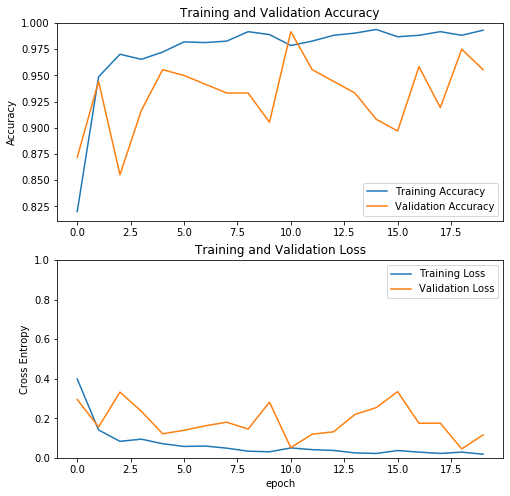

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [6]:
#Save Keras Model
saved_keras_model = args['model']
model.save(saved_keras_model)

In [7]:
#############################################################################
## Quntization for coral.
## This does not work well in Jupyter hub.... Do it in COLAB!!!(Guess version difference is the main reason)
#############################################################################
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(data_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# These set the input and output tensors to uint8
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
# And this sets the representative dataset so we can quantize the activations
converter.representative_dataset = representative_data_gen
tflite_model = converter.convert()

with open('mask_detector.tflite', 'wb') as f:
  f.write(tflite_model)

### wc - quantization - starts here ---------------------------

In [14]:
#wc - quantization
saved_keras_model = 'mask_detector.h5'
model.save(saved_keras_model)

In [17]:
#wc amend - compat.v1
converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(saved_keras_model) #compatible to tensorflow 1
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# These set the input and output tensors to uint8
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
# And this sets the representative dataset so we can quantize the activations
converter.representative_dataset = representative_data_gen
tflite_model = converter.convert()

with open('mask_detector_quant_v2.tflite', 'wb') as f:
  f.write(tflite_model)

### wc - quantization - ends here ---------------------------

In [8]:
batch_images, batch_labels = next(val_generator)

logits = model(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 87.500%


In [9]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('mask_detector.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Quant TF Lite accuracy: 56.250%


In [10]:
print(batch_truth.shape)
print(batch_truth)

print(batch_prediction)
classify_image(interpreter, batch_images[0])

(32,)
[1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0

### wc - compliling - starts here ---------------------------

In [11]:
# Edge tpu compile
# done in jupyter terminal - line by line! (soju server)
# https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf1.ipynb#scrollTo=DhOzAdzF3Dyk

! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler # wc add

! edgetpu_compiler mask_detector_quant_v2.tflite

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0   2687      0 --:--:-- --:--:-- --:--:--  2698
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Hit:1 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease  
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:11 http://a

### wc - compliling - ends here ---------------------------

In [ ]:
print(tf.__version__)

In [ ]:
edgetpu_detect_server \
--model ~/coral_mask/1NN/quantized/one_nn10_edgetpu.tflite \
--labels ~/coral_mask/1NN/quantized/one_nn_label.txt

In [ ]:
192.168.0.23:4664